In [1]:
%matplotlib inline
from bokeh.io import output_notebook
from bokeh.plotting import *
from matmodlab2 import *
from numpy import *
import numpy as np
output_notebook()
import pandas as pd
import matplotlib.pyplot as plt

Setting up the Matmodlab notebook environment


Loading BokehJS ...

: 

In [2]:
def run_model(B_in, load_dir, load_mags, frames=100):
    #B = array([ [ 1, 0, 0], [0, 1, 0 ], [ 0, 0, 1 ] ])
    mps1 = MaterialPointSimulator('uplastic-std')
    p = {'E': 10e6, 'Nu': .333, 'Y0': 1e3, "B": B_in}
    mps1.material = ST_GPSR_TTM(**p)
    mps1.run_step(load_dir, load_mags, frames=50)

    return  mps1.df[['S.XX', 'S.YY', 'S.ZZ', 'S.YZ', 'S.XZ', 'S.XY', 'EP_XX', 'EP_YY', 'EP_ZZ', 'EP_XY', 'EP_YZ', 'EP_XZ', 'EQPS']], mps1

def run_vm(B_in, load_dir, load_mags, frames=100):
    #B = array([ [ 1, 0, 0], [0, 1, 0 ], [ 0, 0, 1 ] ])
    mps1 = MaterialPointSimulator('uplastic-std')
    p = {'E': 10e6, 'Nu': .333, 'Y0': 1e3, "Y1": 0, "m": 0}
    mps1.material = HardeningPlasticMaterial(**p)
    mps1.run_step(load_dir, load_mags, frames=100)

    return  mps1.df[['S.XX', 'S.YY', 'S.ZZ', 'S.YZ', 'S.XZ', 'S.XY']], mps1

def get_yield_point_princ(df, eqps=None):
    if eqps is None:
        y = df[df.EQPS > 1e-6].iloc[0]
    else:
        y = df[df.EQPS > eqps].iloc[0]
    # Build a stress tensor
    s11 = y['S.XX']
    s22 = y['S.YY']
    s33 = y['S.ZZ']
    s13 = y['S.XZ']
    s23 = y['S.YZ']
    s12 = y['S.XY']
    stress_yield = np.array( [ [ s11, s12, s13], [ s12, s22, s23 ], [ s13, s23, s33 ] ] )

    return np.array([s11, s22, s33])

def draw_principal_axes(ax, length_of_axes=2.5, scale=100):
    """
    Draws principal axes on graph, change length of axes and scale
    """
    zero_pos = np.zeros(2)
    straight_up_pos = np.array([0, 1]) * length_of_axes
    bottom_right_pos = np.array([np.cos(-np.pi / 6.), np.sin(-np.pi / 6.)]) * length_of_axes
    bottom_left_pos = np.array([np.cos(7 * np.pi / 6.), np.sin(7 * np.pi / 6.)]) * length_of_axes

    ax.quiver(*zero_pos, *straight_up_pos, scale_units="xy", scale=1)
    ax.annotate(r"$\sigma_2$", straight_up_pos + np.array([0.25, -0.3]) * scale)

    ax.quiver(*zero_pos, *bottom_right_pos, scale_units="xy", scale=1)
    ax.annotate(r"$\sigma_1$", bottom_right_pos + np.array([-0.18, 0.45]) * scale)

    ax.quiver(*zero_pos, *bottom_left_pos, scale_units="xy", scale=1)
    # ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([0.1, -0.45]) * scale)
    ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([0.28, -0.4]) * scale)
    # ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([-0.18, -0.4]) * scale)

def align_pi_plane_with_axes_rot():
    """
    Returns a matrix that rotates the pi plane's normal to be the z axis
    i.e., a slice of pi plane becomes the xy plane after rotation
    """
    pi_vector = np.array([1, 1, 1]) / np.sqrt(3.)
    # wanted_vector = np.array([1, 0, 0])
    wanted_vector = np.array([0, 0, 1])
    wanted_vector = wanted_vector / np.linalg.norm(wanted_vector)
    added = (pi_vector + wanted_vector).reshape([-1, 1])

    # from Rodrigues' rotation formula, more info here: https://math.stackexchange.com/a/2672702
    rot_mat = 2 * (added @ added.T) / (added.T @ added) - np.eye(3)
    return rot_mat


def align_axes_with_pi_plane_rot():
    """
    Returns a matrix that undoes the align_pi_plane_with_axes_rot rotation
    """
    return np.linalg.inv(align_pi_plane_with_axes_rot())


angle_pairs = []
for deg in np.linspace(0,2*np.pi,30):
    N = 1E-3
    SH = 1E-3 #np.sqrt(3)*1e3
    x = N*np.cos(deg)
    y = SH*np.sin(deg)
    angle_pairs.append([x,y])
#print(angle_pairs)
pstress = []
phardstress = []
for angs in angle_pairs:
    #B = array([ [ 1, 0, 0], [0, 1, 0 ], [ 0, 0, 1 ] ])
    #B = array( [ [ -0.225, 0.39, 0.23], [-0.093, 0.41, 0.075], [ -0.258, 0.512, 0.139] ])*5.298
    def B(eqps):
        B_in = 1/(1+500*eqps)*array([ [ .9, 0, 0], [0, .9, 0 ], [ 0, 0, .9 ] ])
        return B_in
    stress, mps = run_model(B, 'EESSSS', (angs[0], angs[1], 0, 0 ,0,0))
    #print(stress)
    #mps.plot('E.XX', 'S.XX')
    prin_stress = get_yield_point_princ(stress)
    pstress.append(prin_stress)
    prin_stress_hard = get_yield_point_princ(stress, eqps=2.631578947368420907e-02)
    phardstress.append(prin_stress_hard)
# for angs in angle_pairs:
#     B = array([ [ 1, 0, 0], [0, 1, 0 ], [ 0, 0, 1 ] ])
#     stress, mps = run_model(B, 'SSSSSS', (0, angs[0], 0, 0,angs[1],0))
#     #print(stress)
#     #mps.plot('E.XX', 'S.XX')
#     prin_stress = get_yield_point_princ(stress)
#     pstress.append(prin_stress)
# for angs in angle_pairs:
#     B = array([ [ 1, 0, 0], [0, 1, 0 ], [ 0, 0, 1 ] ])
#     stress, mps = run_model(B, 'SSSSSS', (0,0, angs[0], 0,0,angs[1]))
#     #print(stress)
#     #mps.plot('E.XX', 'S.XX')
#     prin_stress = get_yield_point_princ(stress)
#     pstress.append(prin_stress)

#print(pstress)


In [ ]:
rot = np.array([[-0.78867513,  0.21132487,  0.57735027],
       [ 0.21132487, -0.78867513,  0.57735027],
       [ 0.57735027,  0.57735027,  0.57735027]])
#print(rot)
s1 = []
s2 = []
for eh in pstress:
    vec = eh @ rot
    s1.append(vec[0])
    s2.append(vec[1])

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\brian\AppData\Local\Temp\ipykernel_109600\1056988179.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma_{11}/Y_0$')
C:\Users\brian\AppData\Local\Temp\ipykernel_109600\1056988179.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma_{22}/Y_0$')


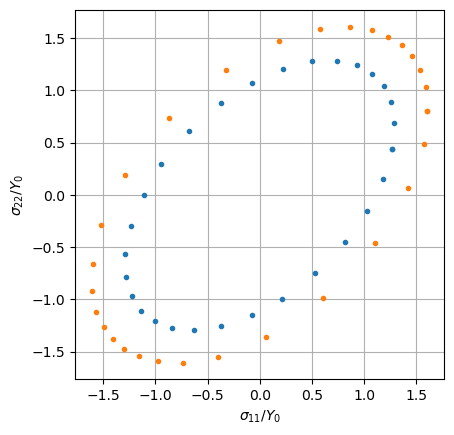

In [ ]:
pstress = np.array(pstress)
phardstress = np.array(phardstress)
plt.plot(pstress[:,0]/1e3, pstress[:,1]/1e3, '.')
plt.plot(phardstress[:,0]/1e3, phardstress[:,1]/1e3, '.')
plt.xlabel('$\sigma_{11}/Y_0$')
plt.ylabel('$\sigma_{22}/Y_0$')
plt.grid()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

In [ ]:
# print(stress.EQPS)